# From coupled quantum wells to energy bands

**Goals (this week):**
- See how mini-bands form when multiple quantum wells are coupled.
- Verify that an effective-mass single-well approximation can reproduce the lower miniband states.
- Construct an E–k diagram from a finite superlattice and compare to the effective-mass model.

The code below contains the device class which also includes the solver for the schrödinger equation; follow the tasks to reproduce and explore the results.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.constants as const
from scipy.linalg import eigh


In [3]:
class MaterialBarrier:
    def __init__(self):
        self.Ec = 13.8*const.e

class MaterialWell:
    def __init__(self):
        self.Ec = 0.0*const.e

class MaterialEffectiveWell:
    def __init__(self, Ec = 1.5*const.e):
        self.Ec = Ec

class Device:
    def __init__(self,dz,N_ew=20,m = const.m_e):
        self.z = np.array([])
        self.Ec = np.array([])
        self.m = m
        self.dz = dz # in m
        self.N_ew = N_ew

    def addLayer(self, size, material): # size in m
        for i in range(np.rint(size/self.dz).astype(int)):
            self.Ec = np.append(self.Ec,material.Ec)
        self.z = np.linspace(0,len(self.Ec),len(self.Ec))*self.dz

    def plot(self, style = '-', scalingFactor = 1.):
        plt.plot(self.z, self.Ec/const.e, 'k', linewidth=0.8)
        plt.xlabel('z in m')
        plt.ylabel('E_c')
        plt.title('Conduction Band')
        for i in range(self.N_ew):
            plt.plot(self.z,self.probability[:,i]*scalingFactor+self.ew[i]/const.e,style, label = 'E_'+str(i))

        
    def getN(self):
        return len(self.z)

    def solveSingleBand(self): 
        print("Solve SingleBand Schrödinger Equation")
        ### BEGIN SOLUTION
        FDE_const = -const.hbar**2/2./self.m/self.dz**2

        #add the conduction band as a potential to the diagonals
        l = self.getN()
        H_1 = scipy.sparse.dia_matrix( (self.Ec,0) , shape = (l , l ))

        #add the second order differential operator
        tmp = -2*np.ones( self.getN() )#*FDE_const
        H_2 = scipy.sparse.dia_matrix( (tmp,0) , shape = (l , l ) )
 
        tmp = 1*np.ones( self.getN() )#*FDE_const
        H_2 += scipy.sparse.dia_matrix( (tmp,-1) , shape = (l , l ) )
        H_2 += scipy.sparse.dia_matrix( (np.roll(tmp,1),1) , shape = (l , l ) )
        
        H = H_1 + H_2*FDE_const 

        self.ew, self.ev = scipy.sparse.linalg.eigsh(H,k=self.N_ew,which = 'SM' )
        self.probability = np.square(np.absolute(self.ev))
        self.probability = self.probability/np.max(self.probability,0)[None,:]

## Task 1a — Build a periodic chain of wells and observe minibands

The code in the cell below constructs a lattice with `N_Wells` quantum wells that are coupled together. Start with `N_Wells = 1` and increase them. You should see minibands forming. 

Hint: With increasing number of quantum wells you need to adapt the `scalingtFactor` such that the wavefunctions don't overlap. Also you might want to set the y-axis limit such that you zoom in on one of the minibands to better observe what happens. 

Solve SingleBand Schrödinger Equation


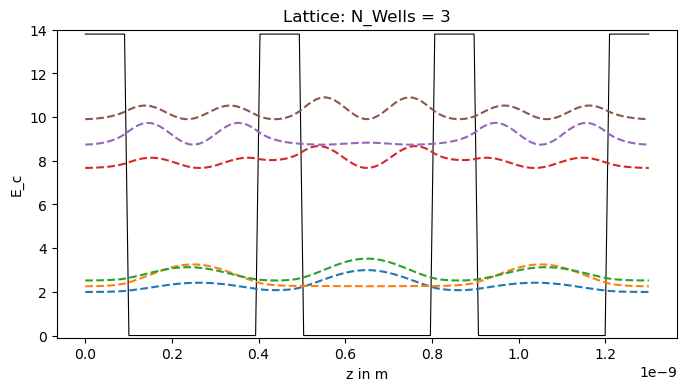

In [23]:
# Parameters
N_Wells = 3

dz = 0.01e-9   # grid spacing in meters (0.01 nm)
lattice = Device(dz, N_ew=N_Wells*2)

# build lattice: small barrier + well repeated
barrier = MaterialBarrier()   # barrier height (eV)
well = MaterialWell()
lattice.addLayer(0.1e-9, barrier)
lattice.addLayer(0.3e-9, well)
for i in range(N_Wells-1):
    lattice.addLayer(0.1e-9, barrier)
    lattice.addLayer(0.3e-9, well)
lattice.addLayer(0.1e-9, barrier)

# Solve and plot
lattice.solveSingleBand()
plt.figure(figsize=(8,4))
lattice.plot('--', scalingFactor=1.)
plt.title(f'Lattice: N_Wells = {N_Wells}')
plt.ylim(-0.1, 14)
plt.show()

### Interpretation 1a) 
manually changed n_wells starting from 1, ... , 10. For n_wells = 1, two humps are confined to the well. As n_wells increases their states cluster forming minibands. At n_wells = 10, scalingFactor needs to be set to 0.2

## Task 1b — Effective-mass single well approximation

Construct a single, infinite well whose width equals the total length of the lattice. Use MaterialEffectiveWell as well material (a single layer uses infinite boundarys). Adjust the effective mass and the band-edge offset (MaterialEffectiveWell) so the first miniband of the lattice matches the low-energy states of the wide well.

Repeat this tuning for the second miniband. (Copy the code cell below, so both solutions are plotted in two different plots.)

Solve SingleBand Schrödinger Equation


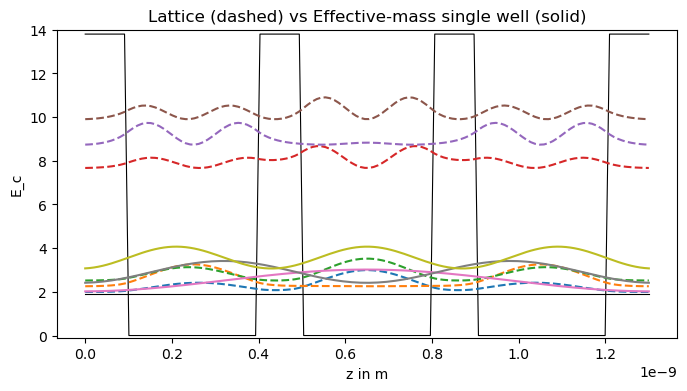

Lattice first few eigenenergies [eV]: [1.99410107 2.25602748 2.51962026 7.67029074 8.73654819 9.90361152]
Effective-mass QW first few eigenenergies [eV]: [2.02020271 2.41373539 3.06937171]


In [24]:
# Effective mass single well
L = lattice.getN() * lattice.dz
m_eff = 1.67 * const.m_e   # example effective mass (tune this)
Ec_eff_eV = 1.889 * const.e           # offset of conduction band for effective well (tune this)

effMassQW = Device(dz, N_ew=N_Wells, m=m_eff)
effMassQW.addLayer(L, MaterialEffectiveWell(Ec_eff_eV))
effMassQW.solveSingleBand()

plt.figure(figsize=(8,4))
lattice.plot('--', scalingFactor=1.0)
effMassQW.plot('-', scalingFactor=1.0)

plt.title('Lattice (dashed) vs Effective-mass single well (solid)')
plt.ylim(-0.1, 14. )
plt.show()

print('Lattice first few eigenenergies [eV]:', lattice.ew[:6]/const.e)
print('Effective-mass QW first few eigenenergies [eV]:', effMassQW.ew[:6]/const.e)

In [ ]:
# Effective mass single well __ 2nd Miniband 
L = lattice.getN() * lattice.dz
m_eff = 1.67 * const.m_e   # example effective mass (tune this)
Ec_eff_eV = 1.889 * const.e           # offset of conduction band for effective well (tune this)

effMassQW = Device(dz, N_ew=N_Wells, m=m_eff)
effMassQW.addLayer(L, MaterialEffectiveWell(Ec_eff_eV))
effMassQW.solveSingleBand()

plt.figure(figsize=(8,4))
lattice.plot('--', scalingFactor=1.0)
effMassQW.plot('-', scalingFactor=1.0)

plt.title('Lattice (dashed) vs Effective-mass single well (solid)')
plt.ylim(-0.1, 14. )
plt.show()

print('Lattice first few eigenenergies [eV]:', lattice.ew[:6]/const.e)
print('Effective-mass QW first few eigenenergies [eV]:', effMassQW.ew[:6]/const.e)

## Task 2 — Construct E–k diagram

We want to use both devices (the lattice and the single effective QW) to get an dispersion relation. We estimate the k-values using a standing-wave counting across the full length. Look at the pattern of the wavefunction and you should see the standing wave - in both the lattice device and the single QW. 

Create a plot which shows the E-k relation of both devices. Make sure you have a matching Ec and mass from Task 1b for your effective QW. Also, make sure that you choose the right miniband from the lattice device. Again, do this plot for both minibands.

In [6]:
L = effMassQW.getN() * effMassQW.dz   # total length in meters

# calculate k-values for n=1..N_Wells by counting the states and scaling with the correct value (think of the standing wave).

# Get the Energy data from the effective QW

# Get the Energy data from miniband of the lattice. Pick the right miniband.


## Task 3 — Dispersion relation from the tight-binding

The lecture notes give us another approach to obtain a E-k relation and the solution to a periodic structure - the Tight-Binding method. 

It leads to the equation

$ E(k) = \frac{\epsilon - 2t\cos(kL)}{1 + 2r\cos(kL)} $

with 

$ t = - \langle \Phi(x) | H | \Phi(x\pm L) \rangle$ and $ r = \langle \Phi(x) | \Phi(x\pm L) \rangle$,

where $\Phi(x)$ is the wavefunction of a quantum well and $L$ is the period of the lattice. 

Hint: This is very similar to the integral of the previous homework Task 3. 

Calculate this and add the solution to a plot including the previous solution from Task 2. 


## Task 4 — Calculate density of states

The density of states is calculated by 

$Z(E) = \frac{1}{L}\frac{\mathrm d N}{\mathrm d E} = \frac{1}{L}\frac{\mathrm d N}{\mathrm d k} \frac{1}{\frac{\mathrm d E}{ \mathrm d k}}$ 

with 

$\frac{\mathrm d N}{\mathrm d k} = \frac{L}{\pi}  $

Use the equation from Task 3 to compute the density of states. Create a plot with two subfigures. In the left subfigure you plot E(k) using the results from Task 3 and in the right plot you plot the density of state with Z on the x-axis and E on the y-axis. A placeholder for this plot is prepared for you.


NameError: name 'k' is not defined

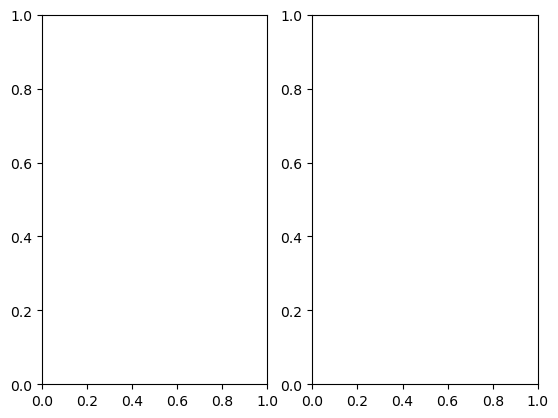

In [7]:
fig, axs = plt.subplots(1,2)

axs[0].plot(k , E)
axs[1].plot(E, Z)

axs[0].set_xlabel('k')
axs[0].set_ylabel('E')
axs[1].set_xlabel('Z')
axs[1].set_ylabel('E')

plt.show()